# **Lettuce canopy segmentation using CNN U-Net**
Adapted from:

204 - U-Net for semantic segmentation of mitochondria
https://github.com/bnsreenu/python_for_microscopists/blob/master/204-207simple_unet_model.py

https://www.youtube.com/watch?v=csFGTLT6_WQ&t=1020s

In [1]:
from keras.utils import normalize
import os
import cv2
from PIL import Image
import keras.metrics
import numpy as np
from matplotlib import pyplot as plt
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

# Step 1: Define coefficient and architecture functions
Using same architecture as original U-Net but using IoU (Jaccard Index) instead of

In [3]:
# https://youtu.be/BNPW1mYbgS4
# u-net model

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)  # -1 ultiplied as we want to minimize this value as loss function

################################################################
def simple_unet_model_with_jacard(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.compile(optimizer = 'adam', loss = [jacard_coef_loss], metrics = [jacard_coef])

    model.summary()

    return model


# Step 2: Load image patches created before

Start by adding the directories for both the original RGB image and its correspondent mask.

In [4]:
image_directory = '../images/patch320_rgb'
mask_directory = '../images/patch320_mask'


SIZE = 320
image_dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.
mask_dataset = []  #Place holders to define add labels. We will add 0 to all parasitized images and 1 to uninfected.


Now, we will iterate in the directories to append each img to our image_dataset. This step ensures we add the correct image size for our Unet.

../images/patch320_rgb0_rgb_0_0.jpg
../images/patch320_rgb0_rgb_0_1.jpg
../images/patch320_rgb0_rgb_0_2.jpg
../images/patch320_rgb0_rgb_1_0.jpg
../images/patch320_rgb0_rgb_1_1.jpg
../images/patch320_rgb0_rgb_1_2.jpg
../images/patch320_rgb0_rgb_2_0.jpg
../images/patch320_rgb0_rgb_2_1.jpg
../images/patch320_rgb0_rgb_2_2.jpg
../images/patch320_rgb0_rgb_3_0.jpg
../images/patch320_rgb0_rgb_3_1.jpg
../images/patch320_rgb0_rgb_3_2.jpg
../images/patch320_rgb0_rgb_4_0.jpg
../images/patch320_rgb0_rgb_4_1.jpg
../images/patch320_rgb0_rgb_4_2.jpg
../images/patch320_rgb0_rgb_5_0.jpg
../images/patch320_rgb0_rgb_5_1.jpg
../images/patch320_rgb0_rgb_5_2.jpg
../images/patch320_rgb100_rgb_0_0.jpg
../images/patch320_rgb100_rgb_0_1.jpg
../images/patch320_rgb100_rgb_0_2.jpg
../images/patch320_rgb100_rgb_1_0.jpg
../images/patch320_rgb100_rgb_1_1.jpg
../images/patch320_rgb100_rgb_1_2.jpg
../images/patch320_rgb100_rgb_2_0.jpg
../images/patch320_rgb100_rgb_2_1.jpg
../images/patch320_rgb100_rgb_2_2.jpg
../images/

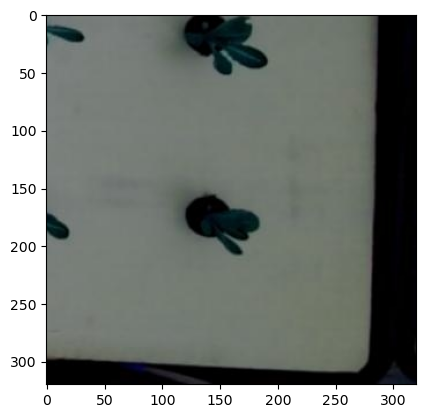

In [8]:
images = sorted(os.listdir(image_directory))
for i, image_name in enumerate(images):    #Remember enumerate method adds a counter and returns the enumerate object
    if (image_name.split('.')[1] == 'jpg'):
        print(image_directory+image_name)
        image = cv2.imread(image_directory+"/"+image_name)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))
        plt.imshow(image)


In [13]:
len(image_dataset)

3348

Then,we iterate thorugh the masks folders

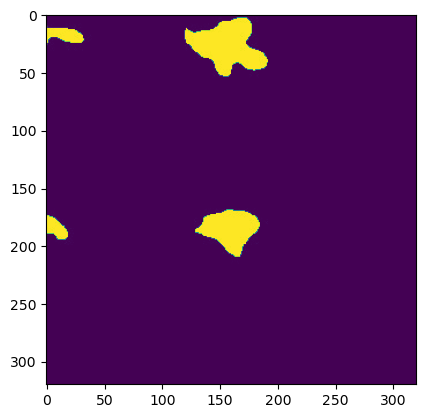

In [11]:
masks = sorted(os.listdir(mask_directory))
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'jpg'):
        image = cv2.imread(mask_directory + '/' + image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        mask_dataset.append(np.array(image))
        plt.imshow(image)

In [12]:
len(masks)

3349

## Image normalization
Now our image values are shown as intensities (0-255) we normalize all values so we have numbers between 0-1

In [14]:
#Normalize images
#image_dataset = np.expand_dims(normalize(np.array(image_dataset), axis=1),1)
image_dataset = normalize(np.array(image_dataset), axis=1)
print(image_dataset.shape)
#D not normalize masks, just rescale to 0 to 1.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.
print(mask_dataset.shape)


(3348, 320, 320, 3)
(3348, 320, 320, 1)


In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 0)

## Sanity check: make sure the images correspond with the masks.

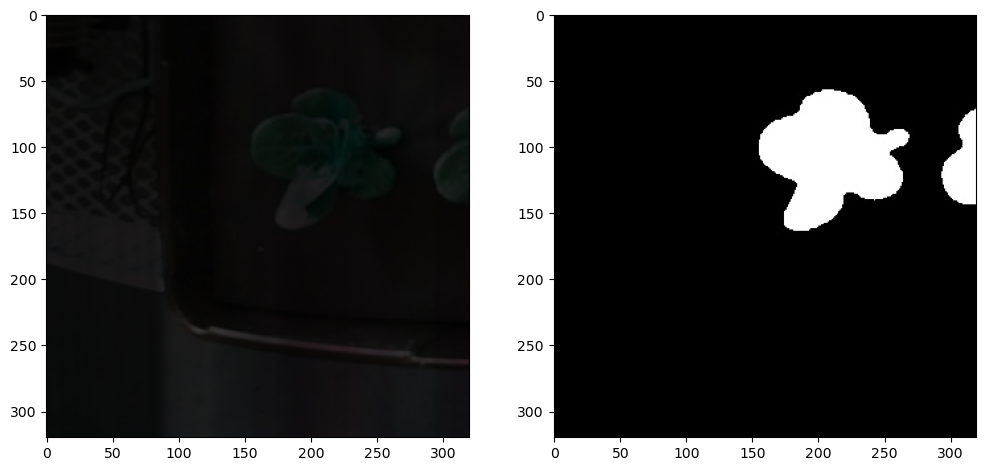

In [16]:
import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (320, 320,3)))
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (320, 320)), cmap='gray')
plt.show()

In [17]:
IMG_HEIGHT = image_dataset.shape[1]
print(IMG_HEIGHT)
IMG_WIDTH  = image_dataset.shape[2]
print(IMG_WIDTH)
IMG_CHANNELS = image_dataset.shape[3]
print(IMG_CHANNELS)

320
320
3


# Defining model based on JACCARD Coefficient

In [18]:
def get_jacard_model():
    return simple_unet_model_with_jacard(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [19]:
model_jaccard = get_jacard_model()




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 320, 320, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 320, 320, 16)         448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 320, 320, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 320, 320, 16)         2320      ['dropout[0][0]']             
                                                                                           

In [20]:
history_jaccard = model_jaccard.fit(X_train, y_train,
                    batch_size =16,
                    verbose=1,
                    epochs=50,
                    validation_data=(X_test, y_test),
                    shuffle=False)

Epoch 1/50


 94/189 [=============>................] - ETA: 2:53 - loss: -0.1787 - jacard_coef: 0.1787

KeyboardInterrupt: 

In [ ]:
model_jaccard.save('/content/drive/MyDrive/Deep_Learning/unet_segmentation/train_model2/jaccard_model_V1.0.hdf5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
_, acc = model_jaccard.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

11/11 [==============================] - 4s 97ms/step - loss: -0.9557 - jacard_coef: 0.9557
Accuracy =  95.56921124458313 %


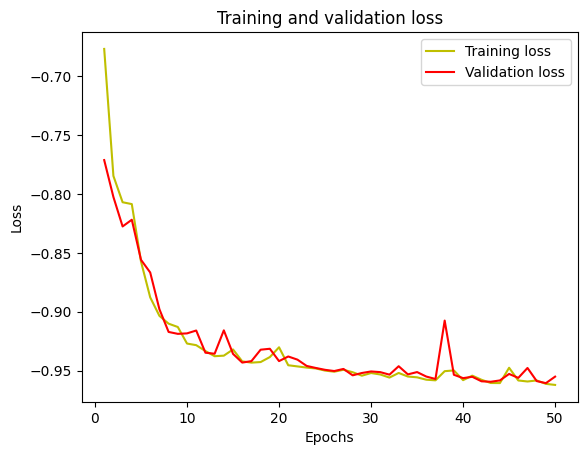

In [ ]:
loss = history_jaccard.history['loss']
val_loss = history_jaccard.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



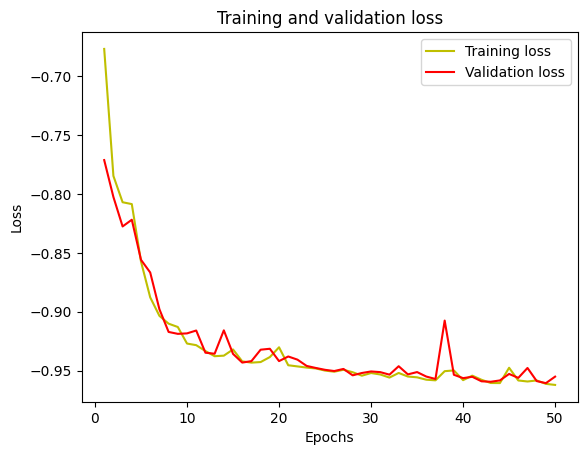

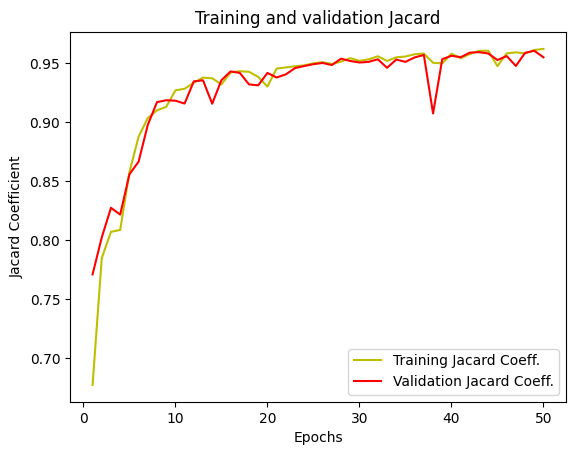

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history_jaccard.history['loss']
val_loss = history_jaccard.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

jc = history_jaccard.history['jacard_coef']
#acc = history.history['accuracy']
val_jc = history_jaccard.history['val_jacard_coef']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, jc, 'y', label='Training Jacard Coeff.')
plt.plot(epochs, val_jc, 'r', label='Validation Jacard Coeff.')
plt.title('Training and validation Jacard')
plt.xlabel('Epochs')
plt.ylabel('Jacard Coefficient')
plt.legend()
plt.show()

In [ ]:
y_pred=model_jaccard.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU score is: ", iou_score)


11/11 [==============================] - 1s 104ms/step
IoU score is:  0.8770101337143892


In [ ]:
test_img_number = 135
test_img = X_test[test_img_number]
print(test_img)
print(test_img.shape)
ground_truth=y_test[test_img_number]
test_img_other_input=np.expand_dims(test_img, 0)
print(test_img_other_input.shape)
prediction = (model_jaccard.predict(test_img_other_input)[0,:,:,0] > 0.5).astype(np.uint8)
#prediction_st = (model_standard.predict(test_img_other_input)[0,:,:,0] > 0.5).astype(np.uint8)

[[[0.05055971 0.04732328 0.06148951]
  [0.04958179 0.04658896 0.06076203]
  [0.04869777 0.04611733 0.06012815]
  ...
  [0.05555715 0.05066984 0.06040994]
  [0.05669007 0.05103535 0.06062043]
  [0.05804913 0.05158011 0.06129893]]

 [[0.05055971 0.04732328 0.06148951]
  [0.04958179 0.04658896 0.06076203]
  [0.04869777 0.04611733 0.06012815]
  ...
  [0.05491856 0.05022923 0.05991477]
  [0.0560531  0.05059915 0.06013155]
  [0.05741122 0.05114666 0.06081243]]

 [[0.04991151 0.04687683 0.06096396]
  [0.04892939 0.04614099 0.06023366]
  [0.04803969 0.0456652  0.05959604]
  ...
  [0.05491856 0.05022923 0.05991477]
  [0.05541614 0.05016295 0.05964268]
  [0.05613542 0.05027977 0.05983943]]

 ...

 [[0.02527985 0.07634227 0.06832168]
  [0.02544329 0.07749895 0.06921588]
  [0.02698119 0.08002714 0.07183451]
  ...
  [0.0530028  0.09605239 0.09705203]
  [0.05541614 0.0964001  0.09728601]
  [0.05613542 0.09622507 0.09729988]]

 [[0.02981726 0.07991384 0.07147499]
  [0.03001003 0.08108272 0.07238607]


In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label (Mask)')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('UNET Prediction on test image')
plt.imshow(prediction, cmap='gray')

size =16
fig,((ax1,ax2),ax3) = plt.subplots(nrows =2,ncols=1,figsize=(12,8))
ax1.set_title('A) Testing Image',fontsize = size)
ax1.set_axis_off()
ax1.imshow(test_img[:,:,0])
ax2.set_title('B) Testing Label (Mask)',fontsize = size)
ax2.set_axis_off()
ax2.imshow(ground_truth[:,:,0],cmap='gray')
ax3.set_title('C) UNET Prediction Jacc Idx',fontsize = size)
ax3.set_axis_off()
ax3.imshow(prediction)
#ax4.set_title('C) UNET Prediction Std',fontsize = size)
#ax4.set_axis_off()
#ax4.imshow(prediction_st)
#plt.savefig('/content/drive/MyDrive/Deep_Learning/Sreeni_UNET/UNET_train/figure.jpg', bbox_inches ="tight",edgecolor ='b', dpi = 300)
plt.show()

NameError: name 'plt' is not defined